# Test repository in the building process

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### 1. Load and Preprocessing

In [2]:
from load import load_train_data
train_df = load_train_data()

In [3]:
from preprocess import preprocess

A_tilde, standardized_train_ratings, train_users, train_items, means, stds, val_users, val_items, orig_val_ratings, standardized_val_ratings = preprocess(train_df)

### 2. Train and Report

TODO:
- try avg on notebook
- try activations on notebook
- try ensamble

#### best run hyperparams:
```python
L=3
K=28
INIT_EMBS_STD=0.075
LR=0.1
WEIGHT_DECAY=0.00005
DROPOUT=0.5

NUM_HEADS=2

# Train loop hyperparameters
EPOCHS=2000
STOP_THRESHOLD=1e-06
```

In [4]:
from train import train_model
from models import LightGCN
from config import DEVICE
from train import train_model
from postprocess import report_training_results

In [5]:
# Model and optimizer hyperparameters
INIT_EMBS_STD=0.075
LR=0.1
WEIGHT_DECAY=0.00005
DROPOUT=0.5
ACT_FN = nn.GELU()

# L=4
# K=28
# PROJECTIONS = (4,)

# Train loop hyperparameters
EPOCHS=2000
STOP_THRESHOLD=1e-06

In [6]:
ks = [28, 30, 32]
layers = [3, 4]
projections = [(4,), (2,), (1,)]  # (8,4) 

In [7]:
# Tuning
for K in ks:
    for L in layers:
        for C in projections:
            print(f"K={K}, L={L}, C={C}")
            model = LightGCN(A_tilde, ACT_FN, K, L, INIT_EMBS_STD, DROPOUT, C).to(DEVICE)
            optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
            loss_fn = nn.MSELoss()
            train_rmse, val_rmse_std, val_rmse_orig = train_model(model, optimizer, loss_fn, train_users, train_items, standardized_train_ratings, val_users, val_items, orig_val_ratings, standardized_val_ratings, means, stds, EPOCHS, STOP_THRESHOLD, True, hyper_verbose=False)
            report_training_results(train_rmse, val_rmse_std, val_rmse_orig)

K=28, L=3, C=(8, 4)
Epoch 0 - Train loss: 1.0035 - Val loss: 3.8269 - Val loss original: 4.0574
Epoch 20 - Train loss: 1.7205 - Val loss: 1.2822 - Val loss original: 1.4014
Epoch 40 - Train loss: 1.0575 - Val loss: 1.0650 - Val loss original: 1.1222
Epoch 60 - Train loss: 1.0298 - Val loss: 1.0556 - Val loss original: 1.1120
Epoch 80 - Train loss: 1.0146 - Val loss: 1.0406 - Val loss original: 1.0956
Epoch 100 - Train loss: 1.0054 - Val loss: 1.0294 - Val loss original: 1.0835
Epoch 120 - Train loss: 0.9989 - Val loss: 1.0215 - Val loss original: 1.0748
Epoch 140 - Train loss: 0.9944 - Val loss: 1.0156 - Val loss original: 1.0683
Epoch 160 - Train loss: 0.9901 - Val loss: 1.0106 - Val loss original: 1.0628
Epoch 180 - Train loss: 0.9879 - Val loss: 1.0061 - Val loss original: 1.0579
Epoch 200 - Train loss: 0.9842 - Val loss: 1.0017 - Val loss original: 1.0533


KeyboardInterrupt: 

### 3. Post-Processing and Submission

min: -2.2434633
max: 1.621278
mean: -0.0030126928


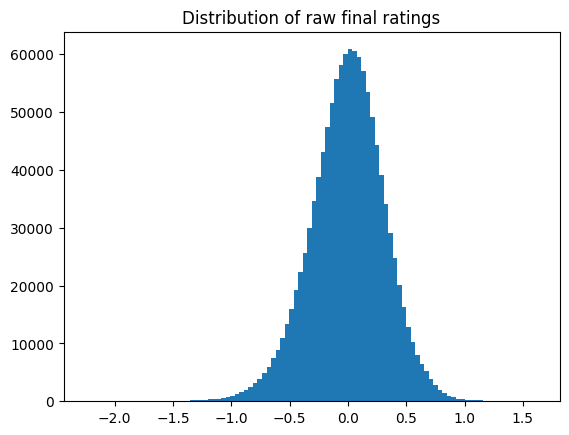

min: 0.4353147273645077
max: 5.5820506002889765
mean: 3.853870303881267
count_over_5: 5437
count_under_1: 25

min: 1.0
max: 5.0
mean: 3.853448503646948


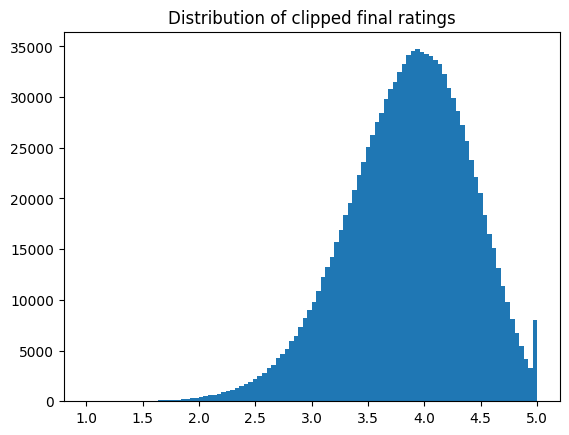

In [ ]:
from postprocess import postprocess
postprocess(model, means, stds)